In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [33]:
df= pd.read_csv('Reviews.csv')
df=df.head(500)
df.shape

(500, 10)

Quick EDA

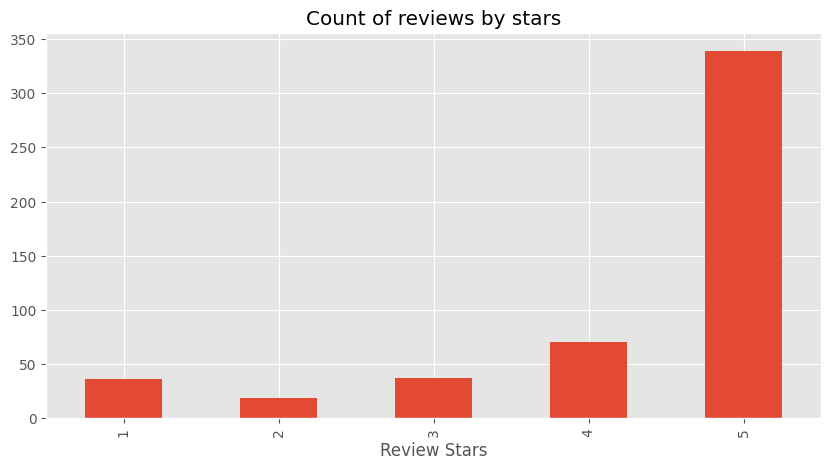

In [34]:
ax=df['Score'].value_counts().sort_index() \
.plot(kind='bar',
      title='Count of reviews by stars',
      figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

BASIC NLTK

In [35]:
example=df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [36]:
tokens=nltk.word_tokenize(example)

In [37]:
tagged=nltk.pos_tag(tokens)

In [38]:
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


VADER SENTIMENT SCORING

In [39]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


In [40]:
sia=SentimentIntensityAnalyzer()

In [41]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [42]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [43]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left')

In [44]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 1.0, 'Compound score by Amazon Star Reviews')

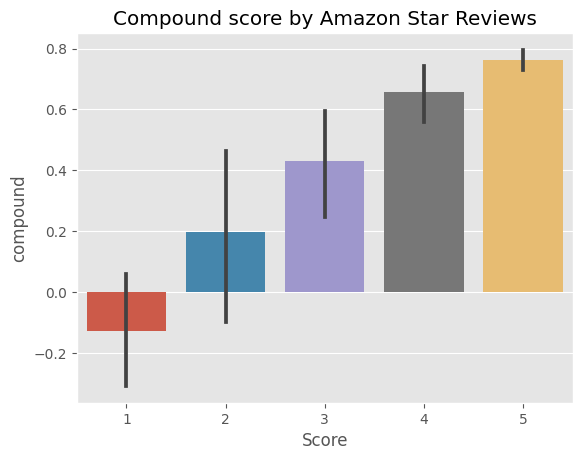

In [45]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound score by Amazon Star Reviews')

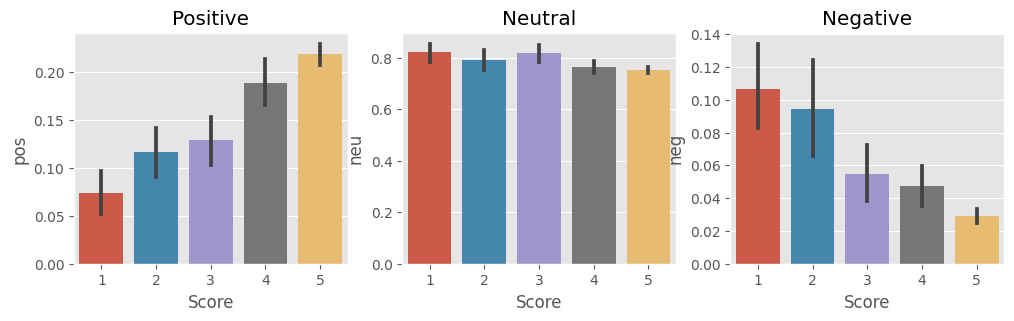

In [46]:
fig,axs=plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

ROBERTA PRETRAINED MODEL

In [47]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [48]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [49]:
#vader result on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [50]:
#Roberta model
encoded_text=tokenizer(example,return_tensors='pt')
output=model(**encoded_text)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.0029573706}


In [51]:
def polarity_scores_roberta(example):
    encoded_text=tokenizer(example,return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    }
    return scores_dict

In [54]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    try:
        text=row['Text']
        myid=row['Id']
        vader_result=sia.polarity_scores(text)
        vader_result_rename={}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"]=value
        roberta_result=polarity_scores_roberta(text)
        both={**vader_result, **roberta_result}
        res[myid]=both
    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id83
Broke for id187


In [55]:
result_df=pd.DataFrame(res).T
result_df=result_df.reset_index().rename(columns={'index':'Id'})
result_df=result_df.merge(df,how='left')

In [56]:
result_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


SCORE COMPARISON

In [57]:
result_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

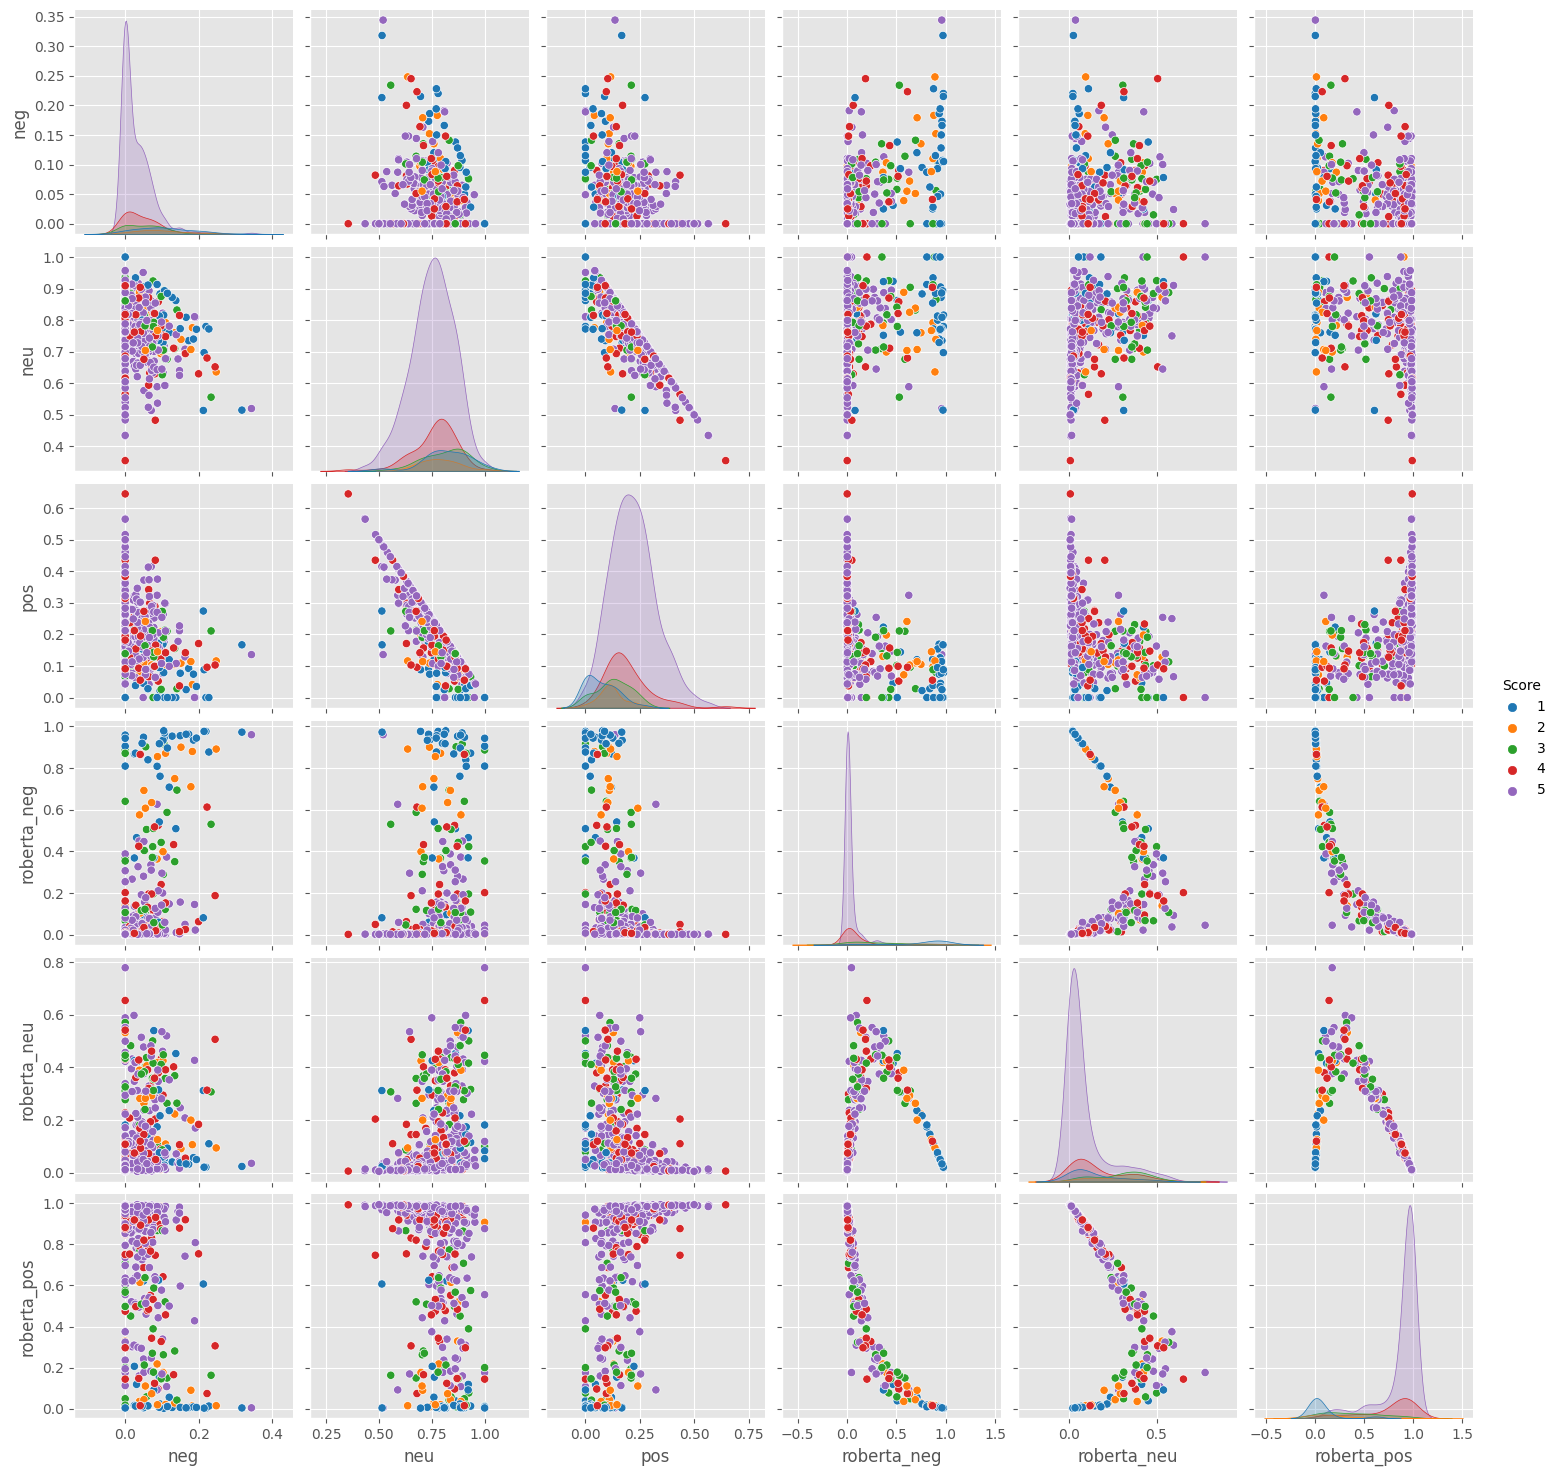

In [58]:
sns.pairplot(data=result_df,vars=['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu',
       'roberta_pos'],hue='Score',
       palette='tab10')

REVIEW EXAMPLES

In [66]:
result_df.query('Score==1').sort_values('pos',ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [67]:
result_df.query('Score==1').sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [68]:
result_df.query('Score==5').sort_values('neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [69]:
result_df.query('Score==5').sort_values('roberta_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

TRANSFORMER PIPELINE

In [71]:
from transformers import pipeline
sent_pipeline=pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [72]:
sent_pipeline('I love sentimental analysis')

[{'label': 'POSITIVE', 'score': 0.9997072815895081}]

In [73]:
sent_pipeline('I hate you')

[{'label': 'NEGATIVE', 'score': 0.9991129040718079}]